### Environment Setup

- `torch`: for processing tensor data and essential deep learning tools for AI training.
- `transformers`: for various open-sorced state-of-art language and multimodal models.
- `datasets`: for a wide range of structured datasets for NLP and vision tasks.
- `accelerate`: for tools that optimize and simplify the AI trianing process.
- `ibm_watson_ai`: for IBM Watson.ai APIs and services.
- `matplotlib`: for additional plotting tools.

##### Installing Required Libraires (takes 10-15 min time)

In [2]:
%%capture
%pip install torch==2.8.0
%pip install transformers==4.55.4
%pip install datasets==3.6.0
%pip install accelerate==1.10.1
# %pip install ibm_watsonx_ai==1.3.13
%pip install gradio==5.45.0
%pip install matplotlib==3.10.6

In [47]:
# !pip show urllib3
# !pip install urllib3==1.26.16

In [6]:
# !pip install -U transformers requests
# !pip install --upgrade transformers accelerate torch

In [1]:
# pip install --upgrade protobuf==3.20.3

In [1]:
#### Importing All Required Libraries

# Libraries for BERT Fine-tuning
import torch
import transformers
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline

# # Watsonx.ai client
# from ibm_watsonx_ai import Credentials
# from ibm_watsonx_ai.foundation_models import ModelInference
# from ibm_watsonx_ai.foundation_models.schema import TextChatParameters, TextChatResponseFormat, TextChatResponseFormatType

# Gradio for simple shareable web app
import gradio as gr

# Basics
import numpy as np
import matplotlib.pyplot as plt

# The following code is used to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# The following library is fur managing directories/folders
import os

/Users/danishkarur/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/danishkarur/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/danishkarur/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <08E12B12-6183-307E-BDA0-374FA8EBA2C9> /Users/danishkarur/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <709C1DF5-D253-3C66-87E2-C99FD3A259DF> /Users/danishkarur/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or 

##### Define Helper Functions

- Constructing Datasets
- Modell Evaluation

In [60]:
def split_data_to_email_url(dataset):
    """
    This function splits the original mixed dataset into
    email and url datasets. The email has labels 0 and 1,
    and the urls have labels 2 and 3.
    """
    emails = []
    urls = []
    
    for data_type in ['train','validation','test']:
        email_content = dataset[data_type].filter(lambda smaple:smaple['label'] in [0,1])
        url_content = dataset[data_type].filter(lambda sample:sample['label'] in [2,3])
        
        emails.append(email_content)
        urls.append(url_content)
    ds_email = concatenate_datasets(emails)
    ds_url = concatenate_datasets(urls)
    
    return ds_email, ds_url


def full_toy_data(dataset_full, n_train_legit, n_train_phish, n_test):
    """
    This function constructs the toy dataset for this project.
    """
    ds_train_leg = dataset_full['train'].filter(lambda example: example['label']==0).shuffle(seed=0).select(range(n_train_legit))
    ds_train_phi = dataset_full['train'].filter(lambda example: example['label']==1).shuffle(seed=0).select(range(n_train_phish))
    content_toy = []
    label_toy = []
    
    for i in range(n_train_legit):
        content_toy.append(ds_train_leg[i]['content'])
        label_toy.append(ds_train_leg[i]['label'])
        content_toy.append(ds_train_phi[i]['content'])
        label_toy.append(ds_train_phi[i]['label'])
        
    ds_train = Dataset.from_dict({'content':content_toy, 'label':label_toy})
    ds_test = dataset_full['test'].select(range(n_test))
    ds = DatasetDict({'train':ds_train, 'test':ds_test})
    return ds

def evaluate(preds,labels):
    """
    This function evaluates the performance of the model by comparing
    its predictions to the ground-truth labels. Five things are evaluated:
        1. Accuracy: percentage of correct predictions
        2. Precision: percentage of correct positives among all predicted positives
        3. Recall: percentage of correct positives among all ground-truth positives
        4. F1-score: the harmonic mean of precision and recall
        5. Confusion Matrix: visualize frequencies of true positives (TP), false positives (FP), true negatives (TN) and false negatives (FN)
    """
    preds = np.array(preds)
    labels = np.array(labels)
    
    # Confusion Matrix
    TP = np.sum((preds==1) & (labels==1)) # phishing correctly predicted 
    TN = np.sum((preds==0) & (labels==0)) # legitimate correctly predicted
    FP = np.sum((preds==1) & (labels==0)) # False alarm
    FN = np.sum((preds==0) & (labels==1)) # missed phishing
    
    # Metrics
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP)> 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN)>0 else 0.0
    
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall)>0 else 0.0
    
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    # Confusion matrix array
    cm = np.array([[TN, FP],
                   [FN, TP]])
    
    classes = ["Legitimate", "Phishing"]
    
    # Add text labels
    labels = [["TP", "FP"],
              ["FN", "TN"]]
    
     # Plot confusion matrix manually
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, cmap="Blues")
    
    # Show numbers inside cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{labels[i][j]}={cm[i, j]}", ha="center", va="center", color="black", fontsize=12)

    # Add labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix")

    # Add colorbar
    plt.colorbar(im, ax=ax)
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


### Preparing PhishingEmailDetectionv2.0 Dataset


Dataset: [PhishingEmailDetectionv2.0](https://huggingface.co/datasets/cybersectony/PhishingEmailDetectionv2.0)

Before training, it’s important to understand the data we are working with. Below are some descriptive statistics of the dataset:

- __Number of samples__: 22,644 Emails and 177,356 URLs
- __Classes__: Legitimate Email (0), Phishing Email (1), Legitimate URL (2), Phishing URL (3)
- __Class distribution__: 5.7% (0), 5.6% (1), 44.3% (2), 44.5% (3)

##### Load Dataset
Load dataset directlty from the huggingface

In [6]:
ds = load_dataset("cybersectony/PhishingEmailDetectionv2.0")
label_mapping = {0: 'legitimate email', 1: 'phishing email', 2: 'legitimate url', 3: 'phishing url'}
print(ds)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/3.17M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/9.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['content', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['content', 'label'],
        num_rows: 60000
    })
})


In [7]:
unique_labels = set(ds['train']['label'])
print("unique_labels",unique_labels)

unique_labels {0, 1, 2, 3}


In [8]:
[f"Label index {label} -> Label value '{label_mapping[label]}'" for label in unique_labels]

["Label index 0 -> Label value 'legitimate email'",
 "Label index 1 -> Label value 'phishing email'",
 "Label index 2 -> Label value 'legitimate url'",
 "Label index 3 -> Label value 'phishing url'"]

To obtain the 100-th smaple from the trianing split

In [9]:
sample = ds['train'][100]
sample

{'content': 'https://www.schloebe.de', 'label': 2}

Here the label `2` i.e legitimate url and URL `https://www.schloebe.de`

This dataset contains three portions: train, validation and test.
    
    Each smaple contains two daafields:
    - First field: "content" for email/url body
    - Second field: "label" for the class

In [20]:
# Seperate the email and the url dataset
ds_email, ds_url = split_data_to_email_url(ds)

In [21]:
ds_email.filter(lambda sample: sample['content']=='empty')[0] #select a missing value data row with filter function

{'content': 'empty', 'label': 1}

In [22]:
# ds_email = ds_email.filter(lambda sample: sample['content']=='empty')[0] # select a missing value data row with filter function

##### Remove the Empty rows by filter function

In [23]:
ds_email = ds_email.filter(lambda sample:sample['content']!='empty')
ds_url = ds_url.filter(lambda sample: sample['content']!='empty')

# for ds_url, we also need to map the tables to 0 and 1

new_url_labels = {2:0,3:1}

def remap_labels(example):
    example['label'] = new_url_labels[example['label']]
    return example

ds_url = ds_url.map(remap_labels)

Filter:   0%|          | 0/22644 [00:00<?, ? examples/s]

Filter:   0%|          | 0/177356 [00:00<?, ? examples/s]

Map:   0%|          | 0/177356 [00:00<?, ? examples/s]

##### Check is there are duplicates inside the dataset ds_email

In [24]:
ds_email.to_pandas().loc[ds_email.to_pandas()['content']== ds_email.to_pandas().value_counts().index[0][0]]

,content,label
4094,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
4764,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
4771,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
6278,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
7622,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
10123,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
13403,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
14217,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
14301,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1
14701,"\nÃÂ \nDear \n Homeowner,ÃÂ ...",1


In [25]:
# All Unique emails
unique_df = ds_email.to_pandas().drop_duplicates(subset="content",keep = "first")

# Convert back to Datasets
ds_email = Dataset.from_pandas(unique_df)

###### The url dataset is left for exercises. Let's print out two sample emails from the ds_email.

In [28]:
# Exploring the training data

num_data = ds_email.num_rows
legit_emails = ds_email.filter(lambda example:example['label']==0)
phish_emails = ds_email.filter(lambda example:example['label']==1)

example_legit_email = legit_emails[0]['content']
example_phish_email = phish_emails[1]['content']

print(f'There are {num_data} training data in total. {legit_emails.num_rows} legit emails and {phish_emails.num_rows} phishing emails.')
print()
print(f'Here is one legitimate email sample: {example_legit_email}.')
print()
print(f'Here is one phishing email sample: {example_phish_email}.')

Filter:   0%|          | 0/17536 [00:00<?, ? examples/s]

Filter:   0%|          | 0/17536 [00:00<?, ? examples/s]

There are 17536 training data in total. 10979 legit emails and 6557 phishing emails.

Here is one legitimate email sample: revised - transitional steering committee meeting here are the details for the transitional steering committee meetings : this meeting will take place every wednesday at 10 : 00 a . m . ( cst ) commencing on february 6 th . dial - in number : 877 - 232 - 4392 host code : 505813 ( louise ) participant code : 969747 tammie schoppe enron americas - office of the chair assistant to louise kitchen 713 . 853 . 4220 office 713 . 646 . 8562 fax 713 . 253 . 2131 mobile.

Here is one phishing email sample: Dear ricardo1 ,
COST EFFECTIVE Direct Email Advertising
Promote Your Business For As Low As 
$50 Per 
1 Million
 Email Addresses
MAXIMIZE YOUR MARKETING DOLLARS!
Complete and fax this information form to 309-407-7378.
A Consultant will contact you to discuss your marketing needs.
NAME:___________________________________________________________________
COMPANY:_____________

###### Split the Dataset into Training and Testing
We use the built-in function of the huggingface datasets to perform the splitting.

One argument we need to set is the `test_size`, which determines the ratio of the test portion to the train portion. The popular choice for `test_size` is 0.2, i.e., 20% of the dataset will be randomly selected to form the test portion. There are other choices as well, for example 75 to 25 split and 70 to 30 split.

In this notebook, we set `test_size=0.2`. We first randomly shuffle the dataset with a specific seed=0 for the purpose of reproducibility by `shuffle`, and then use `train_test_split` for perform the splitting.

In [30]:
ds_email = ds_email.shuffle(seed=0) # random
ds_email = ds_email.train_test_split(test_size = 0.2, shuffle=False)

ds_email

DatasetDict({
    train: Dataset({
        features: ['content', 'label', '__index_level_0__'],
        num_rows: 14028
    })
    test: Dataset({
        features: ['content', 'label', '__index_level_0__'],
        num_rows: 3508
    })
})

##### Construct a Toy Dataset for Training Demo

Since the environment is not equipped with GPUs (Graphical Processing Units), to demonstrate how to fine-tune a BERT-based phishing email detector, we need to construct a much smaller dataset from the original ds_email. What we will do here is to randomly sample 3 legitimate emails and 3 phishing emails (to keep the two classes balanced), and randomly sample 1 email from the test dataset. These two sampling processes are wrapped inside the helper function `full_toy_data`.

Again, this toy dataset is only for demonstration here in the online environment. If you have local GPUs, please ignore this toy dataset construction, and directly head to the training steps. If you are doing your code online, don't worry, we will provide you a pre-trained and saved model configurations later.

In [31]:
ds_toy = full_toy_data(dataset_full=ds_email,
                       n_train_legit = 3,
                       n_train_phish = 3,
                       n_test = 1)

Filter:   0%|          | 0/14028 [00:00<?, ? examples/s]

Filter:   0%|          | 0/14028 [00:00<?, ? examples/s]

In [32]:
print(ds_toy)

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 6
    })
    test: Dataset({
        features: ['content', 'label', '__index_level_0__'],
        num_rows: 1
    })
})


## Fine-TUning BERT for Phishing Email Classification

The Hugging Face Transformers library provides a wide selection of accessible pre-trained models, including various versions of BERT, RoBERTa, and their lightweight distilled counterparts. For this project, we choose the model `distilbert-base-uncased` as our pre-trained backbone.

- `__distilbert-base-uncased__` is a distilled version of BERT that retains most of BERT’s performance while being faster and more memory-efficient.
- The model has been trained on a large corpus of English text and does not differentiate between uppercase and lowercase letters (“uncased”), which is particularly useful in phishing detection since attackers often vary capitalization to evade simple keyword filters.
- The `“distillation”` process refers to knowledge distillation, a technique where a smaller model (the student) is trained to mimic the behavior of a larger, more complex model (the teacher).
- In the case of `DistilBERT`, the student model learns from BERT by approximating its output distributions, capturing most of its representational power while reducing size and computational cost.
-  As a result, DistilBERT is roughly __40% smaller__ and __60% faster__ than BERT, yet preserves about __97%__ of its performance on key NLP benchmarks.

### Load the Base Model

In [33]:
# choose a pre-trained model
model_name = 'distilbert-base-uncased'

#### Text Processing
1. `tokenizer` using `AutoTokenizer`:
    - Input: `model_name`
    - Converts raw text into numerical tokens that model can understand.
    - Splits text into smaller units such as subwords, characters, word pieces. e.g. 'processing' -> 'process' and 'ing'
    - Each token is then mapped to an IntergerID from the model's vocabulary,  e.g. 'process' -> 201, 'ing' -> 520.
    - For `uncased` language models, their tokenizers map the original sentence and its uncased version to the same output. For example, "Where is Peter" and "where is peter" will be tokenized by same tokens.
    
2. `model` using `AutoModelForSequenceClassification`
    - Input: `model_name` and `num_labels` (number of classes, which is 2 in our case: phishing 0 and legitimate 1).
    - Configures the pre-trained model specified by `model_name`.
    - Initializes some new weights for downstream fine-tuning

In [36]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preporcess the Text Data


In [37]:
example = ds_toy['train'][0]['content']
example

'fw : sep ytd originations - - - - - original message - - - - - from : carter , carol sent : thursday , october 04 , 2001 4 : 57 pm to : killen , faith subject : sep ytd originations'

- `input_ids` represents the actual tokenized values of the text
- Notice that `0` tokens are added at the end - these are `padding tokens`.
- `attention_mak` tells the model which token to pay attention
    - A value `1` means the token is real input.
    - A value of `0` menas the token should be ignored (padding)
    
  

In [42]:
# Run tokenizer with padding and truncation

example_tokens = tokenizer(
    example, 
    padding = "max_length",
    truncation = True
)
# How the exampel token looks like
# print("\nExample Token: ",example_tokens)
# Lenght of tokenized input
print("\nLength of input_ids:", len(example_tokens["input_ids"]))

# First 10 input tokens
print("\nFirst 10 input_ids:", example_tokens["input_ids"][:10])

# Last 10 input tokens (should include padding = 0)
print("\nLast 10 input_ids:", example_tokens["input_ids"][-10:])

# Unique set of tokens in the input
print("\nUnique tokens in input_ids:", set(example_tokens["input_ids"]))

# First 10 attention mask values
print("\nFirst 10 attention_mask values:", example_tokens["attention_mask"][:10])

# Last 10 attention mask values (should contain 0 for padding)
print("\nLast 10 attention_mask values:", example_tokens["attention_mask"][-10:])

# Unique values in the attention mask (should be {0, 1})
print("\nUnique values in attention_mask:", set(example_tokens["attention_mask"]))


Length of input_ids: 512

First 10 input_ids: [101, 1042, 2860, 1024, 19802, 1061, 2102, 2094, 4761, 10708]

Last 10 input_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Unique tokens in input_ids: {1024, 0, 2434, 4752, 1042, 8594, 4761, 5401, 3102, 1061, 2860, 2094, 2741, 2102, 7610, 2368, 3395, 5708, 2255, 5840, 2000, 10708, 9432, 19802, 2013, 101, 102, 2541, 1010, 1011, 4471, 1018}

First 10 attention_mask values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Last 10 attention_mask values: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Unique values in attention_mask: {0, 1}


To pass the tokenizer to each data of the dataset, we first define a tokenization function:
- `tokenize_function` - applies the tokenizer to convert to convert each email's content into integer tokens. Key arguments include:
    - `text`: the email body (our input)
    - `padding=max_length`: pads sequences shorter than maximum lenght with [PAD] tokens.
    - `truncation=True`: shortens sequences longer than the maximum length.
    
The `tokenize_function` is then mapped to the entire dataset using .map(), which processes all smaples in batches.

In [43]:
# Create a tokenization function

def tokenize_function(examples):
    return tokenizer(examples['content'], padding='max_length', truncation=True)

# Apply the tokenizer to entire dataset
tokenized_datasets = ds_toy.map(tokenize_function, batched=True)

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

##### Adjustments

- HuggingFace's `Trainer` API, whihc we will be using for fine-tuning.
    1. `input_ids`: the integer sequence of the tokenized text.
    2. `attention_mask`: the binary indicators that tell the model which tokens are real input(1) and which are just padding (0), so it can be ignore padding during attention calculations.
    3. `labels`:class
    
To match with this dataset format, we use the follwoing codes to.
1. Remove original "content" datafield.
2. Rename the "label" datafield to `labels`.
3. Set the data inside the dataset to `torch` datatype.
    


In [45]:
# prepare the data for the model
# Rename the 'labels' column to 'labels' for the Trainer API and remove unneeded columns

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["content"])

# Format the datasets to return PyTOrch tensors
tokenized_datasets.set_format("torch")

#### Begin Fine-Tuning

Set up Trainer API for our BERT model. We first create a `TrainingArguments` class object that contains all the trianing configurations.

__Each Variables__
- `output_dir`: Directory to save the model checkpoints and results.
- `evaluation_strategy`: Defines how often evaluation is run during training (e.g., "epoch" or "steps").
- `per_device_train_batch_size`: Number of training samples processed per device(GPU/CPU) in each forward/backward pass.
- `per_device_eval_batch_size`: Number of evaluation samples processed per device when running validation.
- `num_train_epochs`: NUmber of full passes over the training dataset.
- `logging_dir`: Directory to store training logs for visualization (e.g., TensorBoard).
- `report_to`: Specifies reporting integrations (e.g., "tensorboard", "wandb", or "none") dor monitoring training progress.

In [46]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir = "./results",  # create a new folder "results" in the current directory
    eval_strategy = "epoch",
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 1, # train for 1 epochs
    logging_dir = "./logs", # create a new folder "logs" in the current directory
    report_to = "none",  # we don't use reporting tools here
)



Since our task involves only two classes (__phishing__ vs. __legitimate__), the `Trainer` automatically applies __Binary Cross-Entropy Loss (BCELoss)__ as the optimization objective. Formally, for a single training example, the BCELoss is defined as:  

$$
\mathcal{l}(y, \hat{y}) = - \big[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \big]
$$

where:  
- $y \in \{0,1\}$ is the true label (0 = legitimate, 1 = phishing)  
- $\hat{y} \in [0,1]$ is the predicted probability that the input belongs to class 1 (phishing)  

The overall loss is averaged across all training samples in a batch, that is: 
$$
\mathcal{L}(\{y_i\}_{i=1}^N, \{\hat{y}_i\}_{i=1}^N) = \frac{1}{N}\sum_{i=1}^N \mathcal{l}(y_i,\hat{y}_i)
$$

where $N$ is the number of samples, $\{y_i\}_{i=1}^N$ and $\{\hat{y}_i\}_{i=1}^N$ are the collections of ground-truth labels and predictions respectively. 

Intuitively, the loss $\mathcal{L}$ is designed such that:  

- If the true label is **1** (*phishing*), the model is penalized heavily when it assigns a low probability to phishing.  
- If the true label is **0** (*legitimate*), the model is penalized when it assigns a high probability to phishing.  

By minimizing BCELoss during training, the classifier learns to assign high probabilities to phishing emails and low probabilities to legitimate ones.

Now we use the model, the `training_args`, and the training/evaluation datasets to create a `Trainer` object to carry out fine-tuning. 

At the end, we save the trained model to a specified directory "saved_model" by ``.save_pretrained()``.

<p style="color:#c62828; font-size:1.1rem; font-weight:600; margin:0;">
  This may take over  10-15 minutes
</p>


In [50]:
# Initialize the Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"]
)

# Start training, may take up to 5 minites to go through toy_dataset with 1 epoch
trainer.train()

# Save model to the saved_model_toy folder
model.save_pretrained('./saved_model_toy')

Epoch,Training Loss,Validation Loss
1,No log,0.658249


NOte: The toy model above was trained on only 6 samples, so its predictions are highly unreliable. To demostrate meaningful results, a fully fine-tuned model is found below.

In [51]:
# Create a folder to strore the full model info

directory_name = "saved_model"

if os.path.isdir(directory_name):
    print(f"The directory '{directory_name}' exists.")
else:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created.")

Directory 'saved_model' created.


##### Get the fine-tuned model files frmo the urls.

In [52]:
!wget -P saved_model 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/dCGCWYjklYFBLtc-_dZqXw/config.json'
!wget -P saved_model 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WA2Wr0aaIACXud0--T8Lew/model.safetensors'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-11-03 14:04:51--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/dCGCWYjklYFBLtc-_dZqXw/config.json
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 563 [application/json]
Saving to: 'saved_model/config.json'

config.json         100%[===================>]     563  --.-KB/s    in 0s      

2025-11-03 14:04:52 (179 MB/s) - 'saved_model/config.json' saved [563/563]



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-11-03 14:04:52--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WA2Wr0aaIACXud0--T8Lew/model.safetensors
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267832560 (255M) [application/octet-stream]
Saving to: 'saved_model/model.safetensors'

model.safetensors   100%[===================>] 255.42M  5.76MB/s    in 42s     

2025-11-03 14:05:35 (6.01 MB/s) - 'saved_model/model.safetensors' saved [267832560/267832560]



In [53]:
model_path = directory_name #path to the saved_model folder
num_labels = 2
model_full = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels = num_labels)

##### Pipeline Creation for Easy Inference

- `task`: the type of the downstream task, "text-classification" for this project.
- `model`: the model to be used.
- `tokenizer`: the tokenizer to be used.
- `device`: the computing device, defined by `torch.device()` which sets device as "cpu" by default but "cuda" when gpu is available.
- `top_k`: a positive integer that controls how many of the top-probability labels the pipeline returns  for each input. If `top_k=1`, it will print out the most probable label.

In [55]:
# define the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#create a pipeline for text classification using your fine-tuned model
phishing_detector = pipeline(task="text-classification", model=model_full, tokenizer = tokenizer, device = device, top_k = 1)

Device set to use cpu


### Evalaution on the Test Dataset

Classification Metrics
- __Accuracy__: THe portion of correctly classified emails ot of all test samples.
- __Precision__: THe portion of emails predicted as phishing that are actually phishing.
- __Recall__: THe portion of actual phishing emails correctly identified by the model.
- __F1-Score__: THe harmonic mean of precisions and recall, balancing the trade-off between catching phishing emails and avoainding false alarms.

Confusion Matrix:
- __True Positive(TP)__: Phishing emails correctly identified as phishing.
- __True Negative__(TN): Legitimate emails correctly identifiend as legitimate.
- __Fasle Positive__(FP): Legitimate emails incorrectly flagged as phishing (false alarms)
- __False Negative__(FN): Phishing emails incorrectly classified as legitimate (missed attacks).

__Note__: A Strong phishing detection model should maximize TP and TN, while minimize FP and FN. In practice __high recall__ is particularly important, since missing a phishing email (FN) is more dangerous than ocassionally flagging a legitimate one (FP)

Note: Considering computaitonal constraints, here evaluationg only first 50 test emails in the test dataset.


Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000


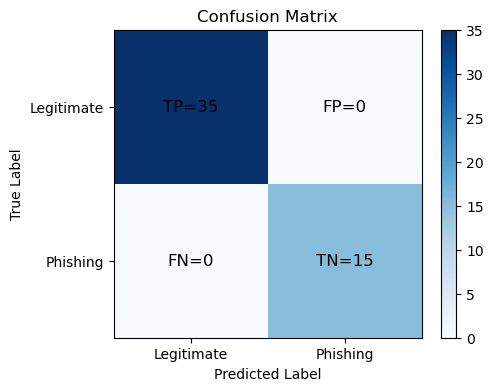

In [61]:
N = 50
ground_truth = ds_email['test']['label'][:N]
email_test = ds_email['test']['content'][:N]

predictions = []

preds = phishing_detector(email_test,truncation=True) #truncation=True for long sequences

for i in range(len(preds)):
    predictions.append(int(preds[i][0]['label'][-1:]))

metrics = evaluate(predictions,ground_truth)

# LLM Applicaiton with IBM Watson

__IBM Granite__ designed to deliver stronger reasoning, longer context handling, and improved performance across business tasks

Key Variables:
- `CREDENTIALS`: Authentication credentials that specify the IBM Cloud endpoint (API keys are optional in this environment).
- `LLM_Granite`: The specific Granite model to load — here we use the 8B Instruct variant, optimized for instruction-following tasks.
- `PROJECT_ID`: The IBM Cloud project where the inference job will run.
- `SYSTEM_PROMPT`: A role-defining instruction that establishes the assistant as a security analyst tasked with analyzing emails and extracting suspicious words or phrases that may indicate phishing attempts.
- `ModelInference` class is used to initialize the Granite model with the given project and credentials, making it ready to process inputs and return structured outputs.

In [ ]:
# Watsonx.ai client
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.schema import TextChatParameters, TextChatResponseFormat, TextChatResponseFormatType

In [ ]:
CREDENTIALS = Credentials(
    url="https://us-south.ml.cloud.ibm.com",
    # api_key = ""
)
LLM_Granite = "ibm/granite-3-3-8b-instruct"
PROJECT_ID = "skills-network"
SYSTEM_PROMPT = """
You are a security assistant. You will be given an email, and please analyze the email and list all suspicious words or phrases that indicate a possible phishing attempt
with explanations. 
At last, give your final judgement by ONLY answering Yes or No, and give your confidence score between 0 to 100.
Please provide your analysis in the following JSON format: { "explanations": "...", "final_judgement": "Yes/No", "confidence_score": 0-100 }.
"""

llm = ModelInference(
                model_id=LLM_Granite,
                credentials=CREDENTIALS,
                project_id=PROJECT_ID
            )

##### Define a function to run the LLM with a given email email_text.

In [ ]:
def analyze_suspicious_contents(email_text):
    response = llm.chat(
                    messages=[
                        {
                            "role": "system",
                            "content": [
                                {"type": "text", "text": SYSTEM_PROMPT}
                            ]
                        },
                        {
                            "role": "user",
                            "content": [
                                {"type": "text", "text": email_text}
                            ]
                        }
                    ]
                )
    return response['choices'][0]['message']['content']

##### Example Run

In [ ]:
#Example
email_text = """Dear Customer,

We noticed unusual activity in your PayPal account. For your protection, your account has been temporarily limited.  

Please verify your account information immediately to avoid suspension.  

Click the secure link below to restore access:  
http://paypa1-security[.]com/verify  

Failure to update your details within 24 hours will result in permanent account closure.  

Thank you for your prompt attention,  
PayPal Security Team"""

phishing_explain = analyze_suspicious_contents(email_text)
print(phishing_explain)

###### Output:

{
  "explanations": "The email claims to be from PayPal Security Team and mentions unusual activity in the recipient's PayPal account, urging immediate action to avoid account suspension. However, there are several suspicious elements: 1) The use of 'Dear Customer' instead of the recipient's name, indicating a generic mass email. 2) The email references clicking a secure link to verify account information, which is a common phishing tactic. 3) The link provided does not belong to PayPal’s official domain but instead uses 'paypa1-security[.]com', which is slightly altered. 4) The threat of permanent account closure if action is not taken within 24 hours creates a sense of urgency, prompting the recipient to act without closely scrutinizing the email's legitimacy.",
  "final_judgement": "Yes",
  "confidence_score": 95
}

Confident score of 95 because several red flags are present, including non-personalization, vague accusation of unusual activity, blatant domain manipulation in the URL, and creation of urgency without providing any specific details through legitimate customer service channels. These elements collectively indicate a high likelihood that this is a phishing attempt.

##### Judgement

Create a dictionary based on the response with `ast.literal_eval()` so that we can extract the answers and scores easily.

`__ast.literal_eval()__` in Python is a function within the `ast` (Abstract Syntax Trees) module that safely evaluates a string containing a Python literal or container display. It is designed to parse and evaluate strings that represent basic Python data structures like numbers, lists and dictionaries etc.

In [ ]:
import ast

response_dict = ast.literal_eval(phishing_explain)
print(response_dict)
print(response_dict['explanations'])
print()
print(f'Final Judgement: {response_dict['final_judgement']}')
print()
print(f'Confidence: {response_dict['confidence_score']}')

## A sharable WebApp with Gradio

`Gradio` is an open-source Python library that makes it easy to build and share interactive web applications for machine learning models with just a few lines of code. It provides user-friendly interfaces such as text boxes, sliders, or file uploaders, allowing anyone to test models in real time directly from a browser.

First, let's define some functions that can organize the BERT predictions.



In [67]:
import json

def organize_predictions(legit, message_show=False):
    label_map = {'LABEL_0':'LEGITIMATE ✅', 'LABEL_1':'SUSPICIOUS ‼️'}
    messages = []
    confidence_scores = []
    for b in range(len(legit)):
        conf_score = -1
        content_type = None
        for item in legit[b]:
            if item['score'] > conf_score:
                conf_score = item['score']
                content_type = label_map[item['label']]
            if message_show:
                print(f"{label_map[item['label']]}, score: {round(item['score'],2)}")
        if message_show: 
            print(f'This content seems to be {content_type}.')
        messages.append(f'This content seems to be {content_type}.')
        confidence_scores.append(conf_score)
    return messages, confidence_scores
        

def phishing_prediction(pipeline, email, message_show=False):
    #We only process one email at a time
    prediction_legit = pipeline(email)
    messages, confidence_scores = organize_predictions(prediction_legit, message_show=message_show)
    return prediction_legit, messages[0], confidence_scores[0]

# Redefine our phishing_detector with top_k=None to have the confidence score.
phishing_detector = pipeline("text-classification", model=model_full, tokenizer=tokenizer, device=device, top_k=None)

# Assemble BERT and LLM into one function
def analyze_email(email):
    prediction_legit, message, conf_score_BERT = phishing_prediction(phishing_detector, email)
    phishing_explain = analyze_suspicious_contents(email)
    print("DEBUG:", phishing_explain)
    try:
        response_dict = json.loads(phishing_explain)
    except Exception:
        print("Response was not JSON:\n", phishing_explain)
        response_dict = {"final_judgement": "Unknown", "confidence_score": "0", "explanations": "Error while processing"}
#     response_dict = eval(phishing_explain)
    conf_score_Granite = int(response_dict['confidence_score'])/100
    conf_score = None #final confidence score

    if conf_score_BERT < conf_score_Granite:
        conf_score = conf_score_Granite
        content_type = 'LEGITIMATE ✅' if response_dict['final_judgement'] == 'No' else 'SUSPICIOUS ‼️'
        message = f'This content seems to be {content_type}.'
    else:
        conf_score = conf_score_BERT
    
    if 0.5 <= conf_score < 0.6:
        decorate = "😐 (low confidence)"
    elif 0.6 <= conf_score < 0.9:
        decorate = "🙂 (medium confidence)"
    else:
        decorate = "💪 (high confidence)"
    conf_score_message = f'{round(conf_score,2)*100}% {decorate}'
    
    return message, conf_score_message, response_dict['explanations']

Device set to use cpu


##### Ready to build out web app. Here are some key components:

- `with gr.Blocks() as demo`: Creates a Gradio app container (`demo`) using the `Blocks` API, which allows you to organize components in rows, columns, and sections.
- `gr.Markdown(...)`: Adds formatted text to the interface. Here, it displays a title (`"Phishing Email Detection Demo"`) and instructions for the user.  
- `email_body = gr.Textbox(...)`:  A multiline textbox where the user pastes the email body to be analyzed.  
- `submit = gr.Button("Analyze Email")`: A button labeled `"Analyze Email"`. When clicked, it triggers the email analysis function.  
- `with gr.Row()`:  Creates a horizontal row layout to place multiple components side by side.  
- `message = gr.Label(label="Message")`: An output label that will display the prediction result (e.g., `"Phishing detected"` or `"Legitimate email"`).  
- `confidence_out = gr.Label(label="Confidence Score")`: An output label that shows the model’s confidence percentage along with an emoji indicator.  
- `explanation_out = gr.Textbox(...)`: A read-only textbox where the suspicious words/phrases are displayed as an explanation. 
- `submit.click(...)`: Links the button to the analysis function.
- `demo.launch(share=True)`: Starts the Gradio app and generates a public shareable link so others can access the phishing detection demo in their browser.  


In [1]:
with gr.Blocks() as demo:
    gr.Markdown("## 🛡️ Phishing Email Detection Demo")
    gr.Markdown("Paste an email below to check if it's suspicious or legitimate.")

    # with gr.Row():
    #     subject = gr.Textbox(label="Email Subject", placeholder="Enter subject")
    email_body = gr.Textbox(label="Email Body", lines=10, placeholder="Paste email content here...")
    submit = gr.Button("Analyze Email")

    with gr.Row():
        message = gr.Label(label="Message")
        confidence_out = gr.Label(label="Confidence Score")
    explanation_out = gr.Textbox(label="Explanation", lines=10, interactive=False)

    submit.click(analyze_email, inputs=[email_body], outputs=[message, confidence_out, explanation_out])

if __name__ == "__main__":
    demo.launch(share=True)

## Conclusion

This notebook demonstrates how modern AI can be applied to phishing email detection effectively. We achieved the following:

- **Fine-tuned Transformer Classifier**:  
  We fine-tuned a lightweight transformer model (e.g., DistilBERT/DistilRoBERTa) on a phishing dataset to classify emails as *legitimate* or *suspicious*.  

- **LLM as a Second Defense Layer**:  
  We integrated a large language model (IBM Granite) to analyze emails further and extract suspicious keywords or phrases that may indicate phishing strategies.  

- **User-Friendly Interface**:  
  We built a Gradio web application that allows users to paste an email, receive a classification result, see the confidence score with visual cues (emojis), and read an explanation of why the email may be risky.  

- **Improved Accuracy and Interpretability**:  
  By combining a fine-tuned classifier with an LLM, the system not only improves detection performance but also increases transparency, helping users trust the results.  

- **Real-World Relevance**:  
  The project highlights how explainable AI tools can enhance cybersecurity by offering both automated detection and human-readable insights.  


## URL Exercise

###### 1. Preprocess the URL dataset for BERT fine-tuning

In [ ]:
# Use the ds_url created before.
# Step 1: shuffle ds_url with seed 0.
ds_url =

# Step 2: split ds_url into train and test portions
ds_url =

# Step 3: tokenize it with .map and tokenize_function
tokenizer_datasets = 

# Step 4: rename the 'labels' column to 'labels' for the Trainer API and remove unneeded columns
tokenized_datasets = #rename labels
tokenized_datasets = #remove contents

# Step 5: format the datasets to return PyTorch tensors

<details>
    <summary>Click here for Solution</summary>

```python
ds_url = ds_url.shuffle(seed=0)

ds_url = ds_url.train_test_split(test_size=0.2, shuffle=False)

tokenized_datasets = ds_url.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets = tokenized_datasets.remove_columns(["content"])

tokenized_datasets.set_format("torch")
```

</details>


##### 2. Exercise 2 - Set up BERT Trainer with respect to the URL dataset

In [ ]:
# Step 0: create a toy dataset for ds_url with 5 legit urls and 5 phishing urls, and 1 test data

# Step 1: create a training argument class with batch size 1 and number of training epochs 2

# Step 2: create a trainer object for the preprocessed URL dataset

# Step 3: start training

# Step 4: save model

<details>
    <summary>Click here for Solution</summary>
    
```python
ds_toy = full_toy_data(dataset_full=ds_url,
                       n_train_legit=5,
                       n_train_phish=5,
                       n_test=1)

training_args = TrainingArguments(
    output_dir="./results",          
    eval_strategy="epoch",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=2,              
    logging_dir="./logs",            
    report_to="none",                
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

# The following model.train() part is suppressed, because
# it would take a lot of time to run on CPU. But for completeness,
# we still include it here, and you may use it for local run.

## Start training
#trainer.train()

## Save the model to the saved_model_toy_url folder
#model.save_pretrained('./saved_model_toy_url/')
```

</details>
